# Paper replicating

## 0. Get setup

In [18]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 3070


In [19]:
import os
import zipfile
import urllib.request
import shutil
from pathlib import Path

# Define the URL of the repository in zip format
url = "https://github.com/mrdbourke/pytorch-deep-learning/archive/refs/heads/main.zip"
zip_filename = "pytorch-deep-learning.zip"
extract_dir = "pytorch-deep-learning-main"
scripts_path = Path("going_modular")

# If the scripts folder doesn't exist, download and prepare it...
if scripts_path.is_dir():
    print(f"{scripts_path} directory exists.")
else:
    # Download the zip file from the URL
    print(f"[INFO] Downloading {url}...")
    urllib.request.urlretrieve(url, zip_filename)

    # Unzip the downloaded file
    print(f"[INFO] Unzipping {zip_filename}...")
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall()

    # Move the necessary files to the working directory
    print("[INFO] Moving necessary files...")

    # Move the going_modular folder
    shutil.move(os.path.join(extract_dir, "going_modular"), ".")

    # Move the helper_functions.py file
    shutil.move(os.path.join(extract_dir, "helper_functions.py"), ".")

    # Remove unnecessary files and folders
    print(f"[INFO] Removing temporary files...")
    os.remove(zip_filename)  # Delete the zip file
    shutil.rmtree(extract_dir)  # Delete the extracted directory

    print("[INFO] Download and extraction completed.")

going_modular directory exists.


## 1. Get the data

In [20]:
import os
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "sidd_small_dataset/SIDD_Small_sRGB_Only/Data"

# SIDD Small Dataset URL
url = "https://competitions.codalab.org/my/datasets/download/a26784fe-cf33-48c2-b61f-94b299dbc0f2"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
        
    # Download sidd small dataset
    with open(data_path / "sidd_small_dataset.zip", "wb") as f:
        request = requests.get(url)
        print(f"Downloading sidd small dataset...")
        f.write(request.content)

    # Unzip sidd small dataset
    with zipfile.ZipFile(data_path / "sidd_small_dataset.zip", "r") as zip_ref:
        print(f"Unzipping sidd small dataset...") 
        zip_ref.extractall(image_path)
        
    # Remove .zip file
    os.remove(data_path / "sidd_small_dataset.zip")

data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data directory exists.


In [21]:
# Listas para almacenar los paths de las imágenes GT y Noisy
image_gt_path_list = []
image_noisy_path_list = []

# Recorremos todas las carpetas
for folder in image_path.iterdir():
    if folder.is_dir():  # Asegurarnos de que sea una carpeta
        # Buscar la imagen GT
        gt_image = folder / "GT_SRGB_010.PNG"
        # Buscar la imagen Noisy
        noisy_image = folder / "NOISY_SRGB_010.PNG"
        
        # Verificar si ambas imágenes existen en la carpeta
        if gt_image.exists() and noisy_image.exists():
            # Añadir los paths a las listas correspondientes
            image_gt_path_list.append(gt_image)
            image_noisy_path_list.append(noisy_image)

# Mostramos los primeros 5 paths de cada lista para verificar
print("GT Image Paths:", image_gt_path_list[:5])
print("Noisy Image Paths:", image_noisy_path_list[:5])
print(f"GT Image Paths size: {len(image_gt_path_list)}")
print(f"Noisy Image Paths size: {len(image_noisy_path_list)}")

GT Image Paths: [PosixPath('data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data/0140_006_IP_00800_00800_3200_L/GT_SRGB_010.PNG'), PosixPath('data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data/0001_001_S6_00100_00060_3200_L/GT_SRGB_010.PNG'), PosixPath('data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data/0094_005_N6_00100_00050_3200_L/GT_SRGB_010.PNG'), PosixPath('data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data/0149_007_G4_00800_00800_4400_L/GT_SRGB_010.PNG'), PosixPath('data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data/0126_006_S6_00400_00200_4400_L/GT_SRGB_010.PNG')]
Noisy Image Paths: [PosixPath('data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data/0140_006_IP_00800_00800_3200_L/NOISY_SRGB_010.PNG'), PosixPath('data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data/0001_001_S6_00100_00060_3200_L/NOISY_SRGB_010.PNG'), PosixPath('data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data/0094_005_N6_00100_00050_3200_L/NOISY_SRGB_010.PNG'), PosixPath('data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data/0149_

## 2. Create Datasets and Dataloaders

In [22]:
import os
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Definimos el dataset customizado para SIDD
class SIDDImageDataset(Dataset):
    def __init__(self, gt_paths, noisy_paths, transform=None):
        self.gt_paths = gt_paths
        self.noisy_paths = noisy_paths
        self.transform = transform

    def __len__(self):
        return len(self.gt_paths)

    def __getitem__(self, idx):
        # Cargar imágenes
        img_gt = Image.open(self.gt_paths[idx])
        img_noisy = Image.open(self.noisy_paths[idx])

        # Aplicar transformaciones si están definidas
        if self.transform:
            img_gt = self.transform(img_gt)
            img_noisy = self.transform(img_noisy)

        return img_gt, img_noisy  # Devolvemos la imagen gt y su correspondiente imagen con ruido

# Definir transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar imagen a (224, 224) 
    transforms.ToTensor(),  # Convertir a tensor en el rango [0, 1]
])

# Crear el dataset
dataset = SIDDImageDataset(image_gt_path_list, image_noisy_path_list, transform=transform)

# Crear el DataLoader con un batch size de 32 imágenes
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Probar una iteración
gt_batch, noisy_batch = next(iter(dataloader))
print(f"Batch de imágenes ruidosas: {noisy_batch.shape}")
print(f"Batch de imágenes GT: {gt_batch.shape}")

Batch de imágenes ruidosas: torch.Size([32, 3, 224, 224])
Batch de imágenes GT: torch.Size([32, 3, 224, 224])


## 3. Visualize random images

102
Random image path: data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data/0030_001_IP_01600_02000_5500_N/GT_SRGB_010.PNG
Image height: 3024
Image width: 4032

Random image path: data/sidd_small_dataset/SIDD_Small_sRGB_Only/Data/0030_001_IP_01600_02000_5500_N/NOISY_SRGB_010.PNG
Image height: 3024
Image width: 4032


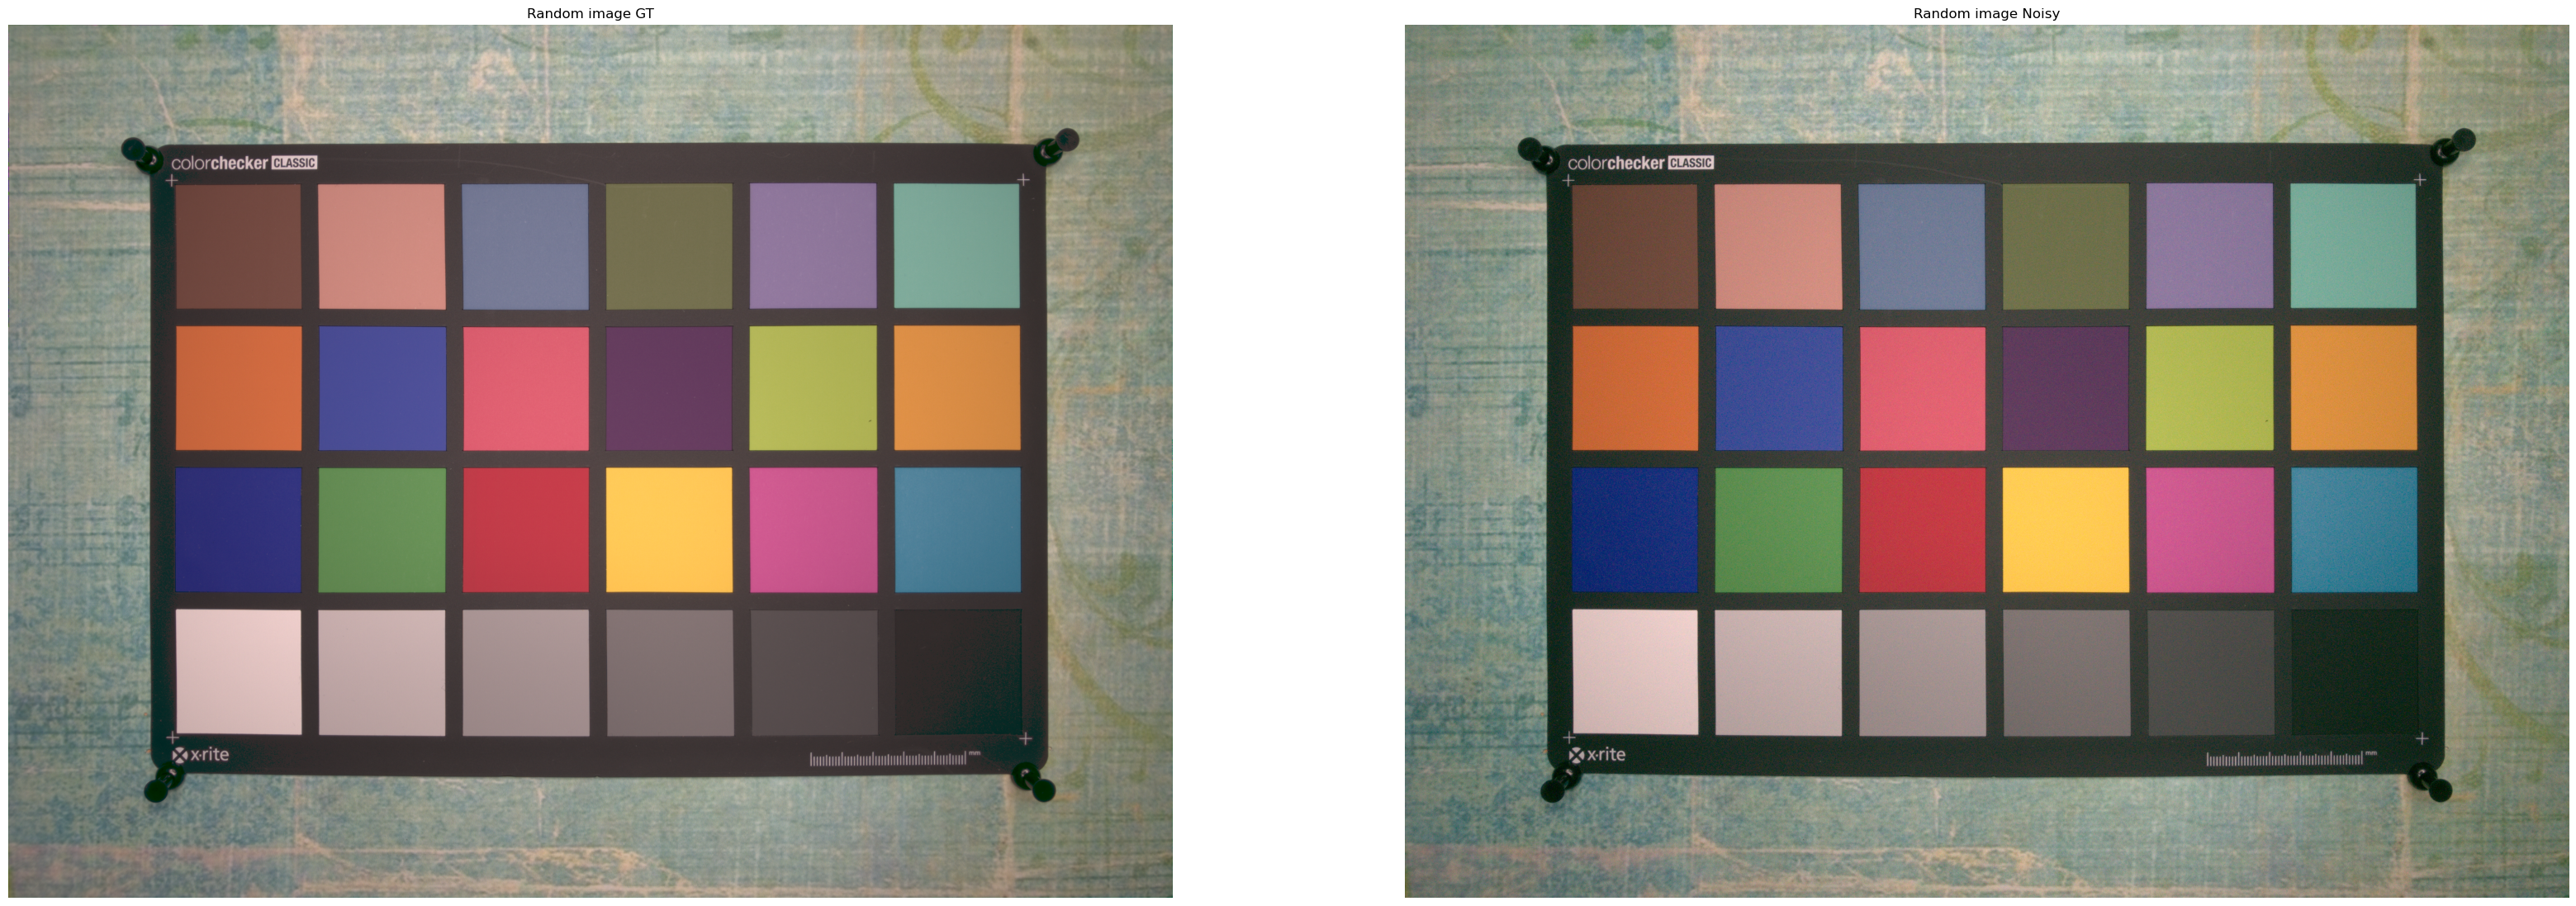

In [15]:
import random
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

# Set seed
# random.seed(42) # <- try changing this and see what happens
random_int = random.randint(0, 159)
print(random_int)

# Get random image path
random_image_gt_path = image_gt_path_list[random_int]
random_image_noisy_path = image_noisy_path_list[random_int]

# Open image
random_img_gt = Image.open(random_image_gt_path)
random_img_noisy = Image.open(random_image_noisy_path)

# Print metadata
print(f"Random image path: {random_image_gt_path}")
print(f"Image height: {random_img_gt.height}") 
print(f"Image width: {random_img_gt.width}\n")

# Print metadata
print(f"Random image path: {random_image_noisy_path}")
print(f"Image height: {random_img_noisy.height}") 
print(f"Image width: {random_img_noisy.width}")

# Visualize images
fig, axs = plt.subplots(1, 2, figsize=(40, 36))

# Image GT
axs[0].imshow(random_img_gt)
axs[0].set_title("Random image GT")
axs[0].axis(False)

# Image Noisy
axs[1].imshow(random_img_noisy)
axs[1].set_title("Random image Noisy")
axs[1].axis(False);

## 4. Replicating ViT

### 4.1. Get images from dataloader

In [23]:
# Get a single image from the batch
image = noisy_batch[5]

# View the single image and label shapes
image.shape

torch.Size([3, 224, 224])

### 4.2. Turning a simple image into patches

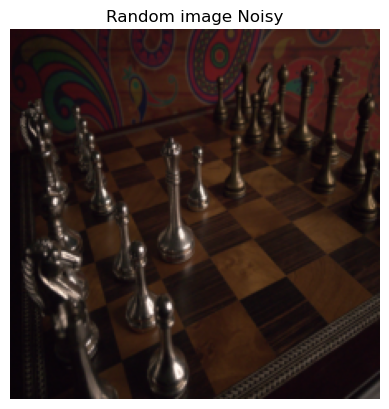

In [26]:
import matplotlib.pyplot as plt

# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title("Random image Noisy")
plt.axis(False);

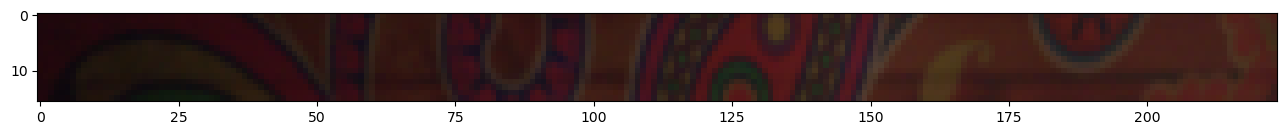

In [28]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # convert image to color channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


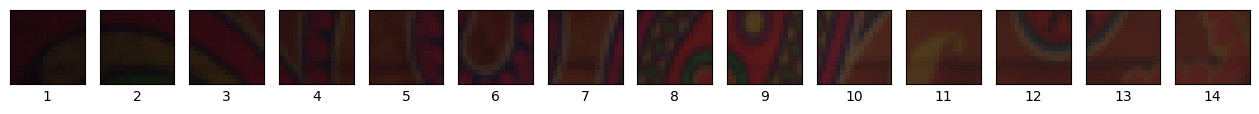

In [31]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(
    nrows=1,
    ncols=img_size//patch_size, # one column for each patch
    sharex=True,
    sharey=True,
    figsize=(patch_size, patch_size)
)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1)  # set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0  
Number of patches per column: 14.0  
Total patches: 196.0  
Patch size: 16 pixels x 16 pixels


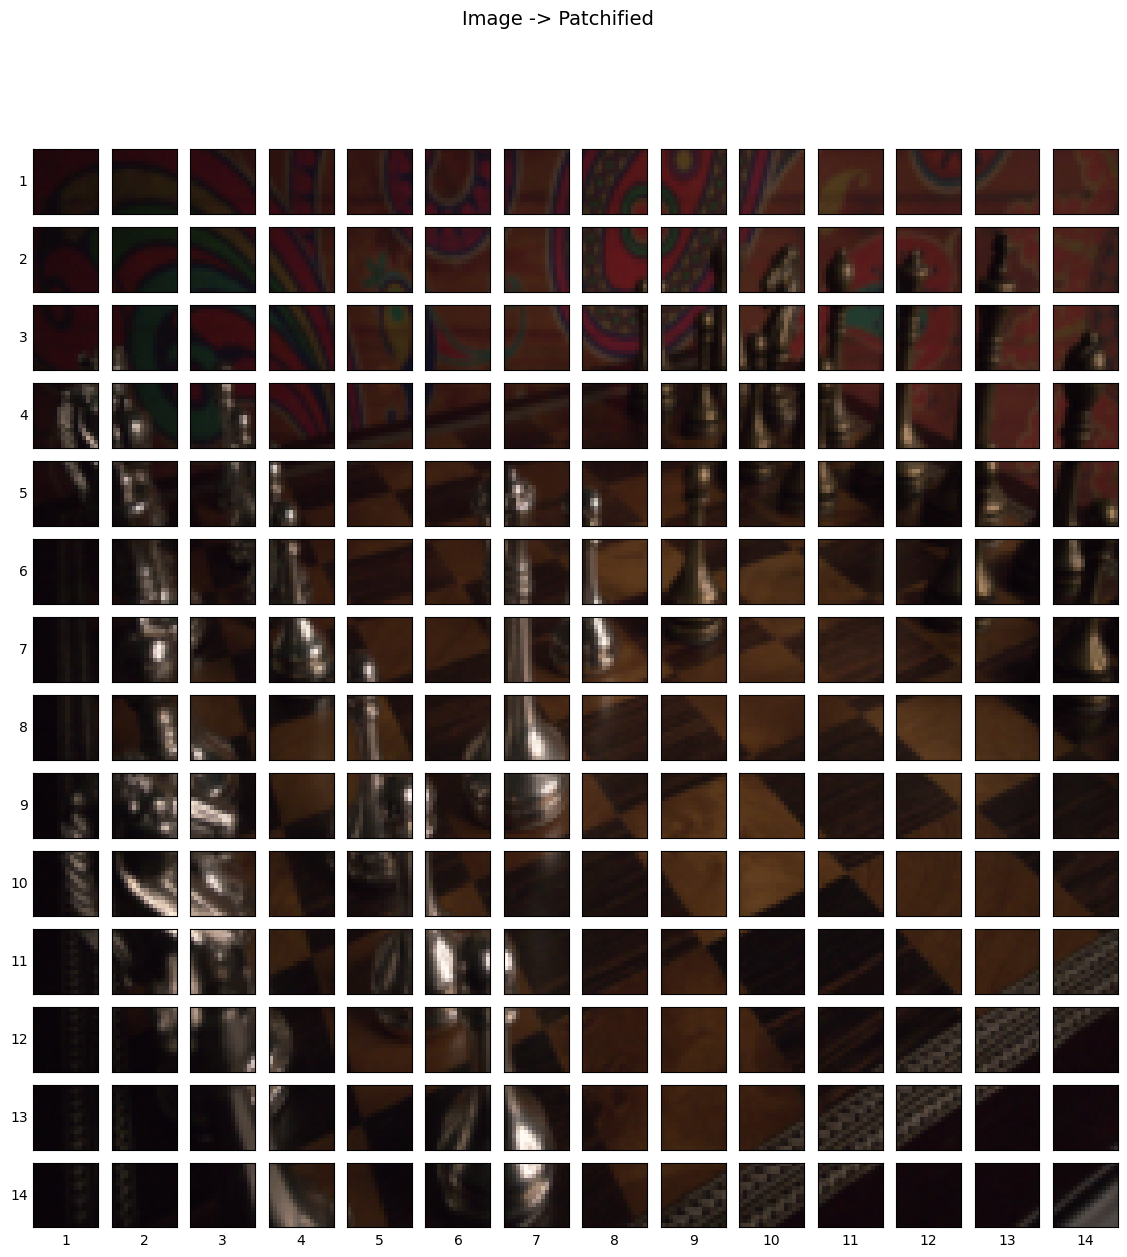

In [30]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
  \nNumber of patches per column: {num_patches}\
  \nTotal patches: {num_patches*num_patches}\
  \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(
    nrows=img_size//patch_size,
    ncols=img_size//patch_size,
    figsize=(num_patches, num_patches),
    sharex=True,
    sharey=True
)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    # Plot the permuted image on the different axes
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                    patch_width:patch_width+patch_size, # iterate through width
                                    :]) # get all color channels
    # Set up label information for each subplot (patch)
    axs[i, j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Set up a title for the plot
fig.suptitle(f"Image -> Patchified", fontsize=14)
plt.show()

### 4.3. Creating image patches and turning them into patch embeddings

In [32]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(
    in_channels=3,  # for color images
    out_channels=768, # D size from Table 1 for ViT-Base
    kernel_size=patch_size,
    stride=patch_size,
    padding=0
)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

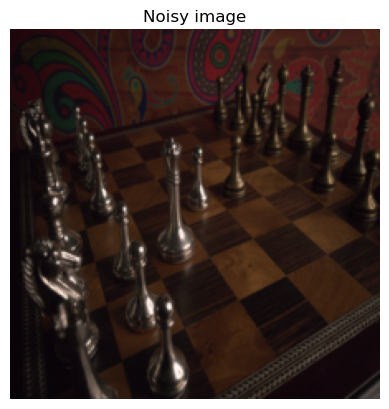

In [33]:
# Visualize single image
plt.imshow(image.permute(1, 2, 0))
plt.title("Noisy image")
plt.axis(False);

In [34]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0))  # add batch dimension -> (batch_size, color_channels, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [35]:
image_out_of_conv.requires_grad

True

Now we've passed a single image to our `conv2d` layer, it's shape is:

```python
torch.Size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Showing random convolutional feature maps from indexes: [470, 300, 559, 483, 708]


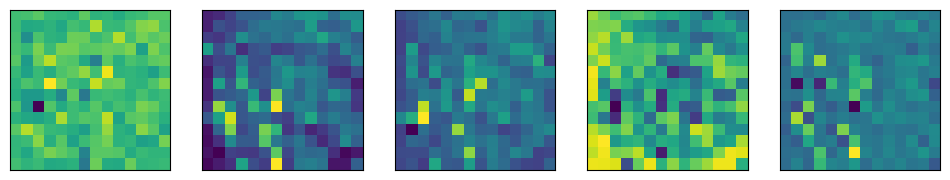

In [36]:
# Plot random convolutional feature maps (embeddings)
import random

random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(
    nrows=1,
    ncols=5,
    figsize=(12, 12)
)

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :]  # index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())  # remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [37]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-9.5291e-03,  6.0495e-03, -1.6688e-02, -2.6016e-02,  4.8067e-03,
           -9.6469e-03, -2.8959e-02, -3.3237e-02, -5.4267e-02,  1.7831e-03,
            1.0469e-02, -3.3822e-02, -3.8250e-02, -1.0590e-02],
          [-4.2370e-02, -6.8388e-02,  3.3756e-02, -3.2006e-02,  4.9880e-03,
           -2.6107e-02,  8.5203e-03, -6.5684e-02,  3.5069e-02, -5.3304e-02,
           -1.9919e-02, -6.0905e-02,  6.9618e-02, -1.3146e-02],
          [-2.2938e-02,  1.6831e-02, -3.6691e-02,  7.0739e-03, -2.9369e-03,
           -5.4783e-02, -2.1141e-02, -2.9666e-02,  7.3052e-02,  1.2956e-01,
           -4.3269e-02, -2.9220e-02, -3.7096e-02,  2.2656e-03],
          [-5.5417e-02, -5.9191e-02, -6.5821e-02, -3.2825e-02, -9.6240e-03,
            1.2220e-02, -1.8037e-02, -4.2429e-02,  3.4621e-02,  6.4220e-02,
           -1.5140e-02,  7.0265e-02, -3.3004e-02,  1.0484e-03],
          [ 4.0784e-02, -5.3829e-02,  3.9489e-02,  1.7342e-03, -1.8441e-02,
           -6.4829e-02,  7.0423e-02, -5.2700e-03,  4.9151e-0

### 4.4. Flattening the patch embedding with `torch.nn.Flatten()`

In [38]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


In [39]:
from torch import nn

flatten_layer = nn.Flatten(
    start_dim=2,
    end_dim=3
)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


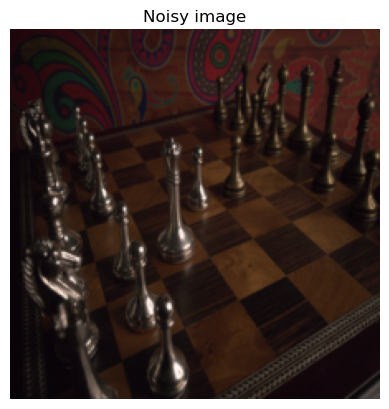

In [40]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title("Noisy image")
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))  # add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [41]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


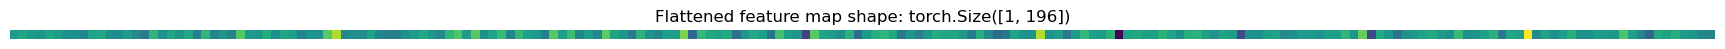

In [42]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);